<a href="https://colab.research.google.com/github/SeongjiGo/FingerNumber_classifier/blob/master/FingerNumber_classifier_V0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
# 데이터 셋 구성하기, 경로를 파악한 후
# 클래스 이름(name), 클래스(class), 그리고 학습을 위한 클래스를 숫자로 나타낸 타겟(target)을 csv파일에 저장
import os
from glob import glob # 인자로 받은 패턴과 이름이 일치하는 모든 파일과 디렉터리의 리스트 반환
import pandas as pd

file_path = './drive/MyDrive/FingerNumber_classifier_project/dataSet/*/*.png' # 데이터의 경로 저장
file_list = glob(file_path)

data_dict = {'image_name':[], 'class':[], 'target':[], 'file_path':[]}
# 학습에 사용하기 위한 넘버링(?)
target_dict = {'yi_1': 0, 'er_2': 1, 'san_3': 2, 'si_4':3, 'wu_5':4, 'liu_6':5, 'qi_7':6, 'ba_8':7, 'jiu_9':8, 'shi_10': 9}

for path in file_list:
    data_dict['file_path'].append(path) # file_path 항목에 파일 경로 저장

    path_list = path.split(os.path.sep) # os별 파일 경로 구분 문자로 split

    data_dict['image_name'].append(path_list[-1]) # 이미지 이름 저장
    data_dict['class'].append(path_list[-2]) # 어떤 클래스인지 저장
    data_dict['target'].append(target_dict[path_list[-2]]) # 그 클래스의 번호 저장

train_df = pd.DataFrame(data_dict) # 데이터 프레임 화
train_df.to_csv("./drive/MyDrive/FingerNumber_classifier_project/train.csv", mode='w') # csv파일로 생성
print('csv파일 생성 완료!')



csv파일 생성 완료!


In [79]:
from sklearn.model_selection import train_test_split # 스플릿 모듈
def get_df():
    # csv 파일 읽어서 DataFrame으로 저장
    df = pd.read_csv("./drive/MyDrive/FingerNumber_classifier_project/train.csv") # csv로 불러와서 데이터 저장
    print('csv 파일 DataFrame으로 저장 완료!')

    # 데이터셋을 train, val, test로 나누기
    df_train, df_test = train_test_split(df, test_size=0.1)
    df_train, df_val = train_test_split(df_train, test_size=0.2)
    print('훈련셋, 검증셋, 테스트셋 분할 완료!')
    return df_train, df_val, df_test

# 데이터셋 읽어오기
df_train, df_val, df_test = get_df()
print(f'훈련셋 개수:{len(df_train)}, 검증셋 개수:{len(df_val)}, 테스트셋 개수: {len(df_test)}') # 192, 48, 60



csv 파일 DataFrame으로 저장 완료!
훈련셋, 검증셋, 테스트셋 분할 완료!
훈련셋 개수:216, 검증셋 개수:54, 테스트셋 개수: 30


In [80]:
import torch
from torch.utils.data import Dataset
from PIL import Image

# 학습시, 데이터셋을 사용할 수 있도록 만들기
class Classification_Dataset(Dataset):
    def __init__(self, csv, mode, transform=None):
        self.csv = csv.reset_index(drop=True) # random으로 섞인 데이터의 인덱스를 reset 시켜서 다시 부여한다.
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0] # csv 파일의 행 개수 == 데이터 개수

    def __getitem__(self, index):
        row = self.csv.iloc[index] # 주어진 index에 대한 데이터 뽑아오기
        image = Image.open(row.file_path).convert('RGB') # 파일 경로로 부터 이미지를 읽고 rgb로 변환하기
        target = torch.tensor(self.csv.iloc[index].target).long()

        if self.transform:
            image = self.transform(image) # 이미지에 transform 적용하기

        return image, target # 이미지와 target return하기기



In [81]:

# normalize를 위해 rgb 채널의 mean, std 값 구하기

import numpy as np
from torchvision import transforms
dataset_train = Classification_Dataset(df_train, 'train', transform=transforms.ToTensor())

rgb_mean = [np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset_train]
rgb_std = [np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset_train]

# 각 데이터 채널별로 mean, std 나타내기
c_mean = []
c_std = []
for i in range(3):
    c_mean.append(np.mean([m[i] for m in rgb_mean]))
    c_std.append(np.std([s[i] for s in rgb_std]))

print('rgb의 mean, std값 계산 완료!')

rgb의 mean, std값 계산 완료!


In [82]:

# 사용자 모델 트랜스폼
def get_transforms(image_size):
    transforms_train = transforms.Compose([
        transforms.RandomRotation(30), # 이미지의 다양화를 위해 랜덤으로 +- 30도 가량 회전
        transforms.RandomResizedCrop(image_size), # 이미지 사이즈 축소
        transforms.RandomHorizontalFlip(), # 이미지를 랜덤으로 수평하게 뒤집음.
        transforms.ToTensor(), # 데이터 타입을 텐서로 변경
        transforms.Normalize(c_mean, c_std) ]) # 정규화

    transforms_val = transforms.Compose([transforms.Resize(image_size + 30), 
                                            transforms.CenterCrop(image_size), # 이미지의 가운데 부분을 인자값으로 자름
                                            transforms.ToTensor(),
                                            transforms.Normalize(c_mean, c_std)])
    
    transforms_test = transforms.Compose([transforms.Resize(image_size),
                                            transforms.ToTensor(),
                                            transforms.Normalize(c_mean, c_std)]) # 정규화

    return transforms_train, transforms_val, transforms_test

# 모델 트랜스폼 가져오기
transforms_train, transforms_val, transforms_test = get_transforms(224)
print("모델 트랜스폼 불러오기 완료!")


모델 트랜스폼 불러오기 완료!


In [83]:
# dataset class 객체 만들기
dataset_train = Classification_Dataset(df_train, 'train', transform=transforms_train)
dataset_val = Classification_Dataset(df_val, 'valid', transform=transforms_val)
dataset_test = Classification_Dataset(df_test, 'test', transform=transforms_test) 
print('dataset class 객체 생성 완료!')

# DataLoader는 Classification_Dataset으로 받아온 데이터(이미지, target)를 batch로 묶어 return합니다.
from torch.utils.data.sampler import RandomSampler
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=1, sampler=RandomSampler(dataset_train), num_workers=0)
valid_loader = torch.utils.data.DataLoader(dataset_val, batch_size=1, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1, num_workers=0)
print('데이터 로더 완료!')
#### 데이터 준비 파트는 마무리가 되었습니다. 큰 틀을 살펴보면서 정리해보도록 하겠습니다.
# 0. 데이터셋 다운받기`: 여러분이 수집한 데이터의 클래스별로 폴더를 구성하여 데이터셋을 준비합니다.
# 1. 데이터셋 구성하기`: 저장한 데이터의 정보를 csv 파일로 만듭니다.
# 2. 데이터셋 불러오기`: csv 파일을 통해 데이터를 불러와서 train, validation, test로 나눠줍니다.
# 3. 학습 시, 데이터셋을 사용할 수 있도록 만들기
#     3-1. Dataset Class`: pytorch가 dataset을 어떻게 읽을지 알려주는 클래스를 만듭니다. (데이터셋 크기와 지정한 인덱스별로 데이터를 리턴해주는 len, getitem 함수가 포함되어 있습니다.)
#     3-2. Transforms & Augmentation`: 학습을 위해 데이터를 가공합니다.
#     3-3. Data Loaders`: 배치별로 데이터를 묶어줍니다. Training시, 배치단위별로 데이터가 호출됩니다.

dataset class 객체 생성 완료!
데이터 로더 완료!


In [77]:
# Model 설정
from torchvision import models
from collections import OrderedDict
import torch.nn as nn

model = models.vgg16(pretrained=True)

# Backprop을 수행하지 않도록 parameter들을 동결시키기
# # 재학습을 위해, 모든 parameters의 gradient를 꺼놓기
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 500)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(500, 10))
]))

model.classifier = classifier
print('VGG16 셋팅 완료')

# Training

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG16 셋팅 완료


In [84]:
import numpy as np
import cv2
import random
import time
import torch.optim as optim

from tqdm import tqdm # tqdm은 작업의 진행률을 시각적으로 표시해준다.

# train
def train_epoch(model, loader, device, criterion, optimizer):
    model.train() # 모델 train 모드로 바꾸기
    train_loss = []
    bar = tqdm(loader)

    for i, (data, target) in enumerate(bar):
        optimizer.zero_grad() # 최적화된 모든 변수 초기화

        data, target = data.to(device), target.to(device) # 지정한 device로 데이터 옮기기
        logits = model(data) # 1. forward pass
        loss = criterion(logits, target) # 2. loss계산
        loss.backward() # 3. backward pass
        optimizer.step() # 4. gradient descent(파라미터 업데이트)

        loss_np = loss.detach().cpu().numpy() # loss값 가져오기 위해 gpu에 있던 데이터 모두 cpu로 옮기기
        train_loss.append(loss_np)
        bar.set_description('loss: %.5f' % (loss_np))

    train_loss = np.mean(train_loss) # 한 epoch당 train loss의 평균 구하기
    return train_loss

# Validation
def val_epoch(model, loader, device, criterion):
    model.eval() # 모델 evaluate 모드로 바꾸기
    val_loss = []
    LOGITS = []
    PROBS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)    # 1. forward pass
            probs = logits.softmax(1)

            LOGITS.append(logits.detach().cpu())
            PROBS.append(probs.detach().cpu())
            TARGETS.append(target.detach().cpu())

            loss = criterion(logits, target)    # 2. loss 계산
            val_loss.append(loss.detach().cpu().numpy())

    val_loss = np.mean(val_loss)
    LOGITS = torch.cat(LOGITS).numpy()
    PROBS = torch.cat(PROBS).numpy()
    TARGETS = torch.cat(TARGETS).numpy()

    # accuracy: 정확도
    acc = (PROBS.argmax(1) == TARGETS).mean() * 100.

    return val_loss, acc

In [85]:
# 학습시키기

minLoss = 10000
def run(model = model, init_lr = 0.1, n_epochs = 15):
    global minLoss
    # gpu 사용
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"현재 장치: {device}")
    # model을 지정한 장치로 옮기기
    model = model.to(device)

    # loss function 지정
    criterion = nn.CrossEntropyLoss()

    # optimizer로 adam 사용
    optimizer = optim.Adam(model.parameters(), lr = init_lr)
    
    train_losses = []
    val_losses = []
    accurates = []
    
    for epoch in range(1, n_epochs + 1):
        print(time.ctime(), f'Epoch {epoch}')
        optimizer.param_groups[0]["lr"] = init_lr / (epoch ** 0.5)
        train_loss = train_epoch(model, train_loader, device, criterion, optimizer) # train
        val_loss, acc = val_epoch(model, valid_loader, device, criterion) # validation

        content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {(val_loss):.5f}, Acc: {(acc):.4f}.'
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accurates.append(acc)
        print(content)

        if val_loss < minLoss:
            torch.save(model, '/content/drive/MyDrive/FingerNumber_classifier_project/best_model.pth')
            minLoss = val_loss
            print("최소의 로스값이 나왔습니다. 모델을 새로 저장합니다.")
    
    return train_losses, val_losses, accurates


모델을 새로 학습합니다.
원하는 에포크 수를 입력해주세요: 30
30으로 에포크를 설정하였습니다.
모델 학습을 시작합니다.
현재 장치: cuda
Sat Dec 11 14:26:36 2021 Epoch 1


100%|██████████| 54/54 [00:02<00:00, 24.85it/s]


Sat Dec 11 14:26:49 2021 Epoch 1, lr: 0.0010000, train loss: 5.16654, valid loss: 1.90253, Acc: 33.3333.
최소의 로스값이 나왔습니다. 모델을 새로 저장합니다.
Sat Dec 11 14:26:50 2021 Epoch 2


100%|██████████| 54/54 [00:02<00:00, 25.05it/s]


Sat Dec 11 14:27:03 2021 Epoch 2, lr: 0.0007071, train loss: 1.99961, valid loss: 1.28226, Acc: 48.1481.
최소의 로스값이 나왔습니다. 모델을 새로 저장합니다.
Sat Dec 11 14:27:04 2021 Epoch 3


100%|██████████| 54/54 [00:02<00:00, 25.00it/s]


Sat Dec 11 14:27:18 2021 Epoch 3, lr: 0.0005774, train loss: 1.65967, valid loss: 0.93562, Acc: 62.9630.
최소의 로스값이 나왔습니다. 모델을 새로 저장합니다.
Sat Dec 11 14:27:18 2021 Epoch 4


100%|██████████| 54/54 [00:02<00:00, 25.21it/s]


Sat Dec 11 14:27:32 2021 Epoch 4, lr: 0.0005000, train loss: 1.49773, valid loss: 1.24641, Acc: 55.5556.
Sat Dec 11 14:27:32 2021 Epoch 5


100%|██████████| 54/54 [00:02<00:00, 25.55it/s]


Sat Dec 11 14:27:45 2021 Epoch 5, lr: 0.0004472, train loss: 1.34989, valid loss: 0.88328, Acc: 66.6667.
최소의 로스값이 나왔습니다. 모델을 새로 저장합니다.
Sat Dec 11 14:27:46 2021 Epoch 6


100%|██████████| 54/54 [00:02<00:00, 24.94it/s]


Sat Dec 11 14:27:59 2021 Epoch 6, lr: 0.0004082, train loss: 1.27571, valid loss: 0.77631, Acc: 72.2222.
최소의 로스값이 나왔습니다. 모델을 새로 저장합니다.
Sat Dec 11 14:28:00 2021 Epoch 7


100%|██████████| 54/54 [00:02<00:00, 25.35it/s]


Sat Dec 11 14:28:14 2021 Epoch 7, lr: 0.0003780, train loss: 1.09545, valid loss: 0.79729, Acc: 74.0741.
Sat Dec 11 14:28:14 2021 Epoch 8


100%|██████████| 54/54 [00:02<00:00, 25.16it/s]


Sat Dec 11 14:28:27 2021 Epoch 8, lr: 0.0003536, train loss: 1.00258, valid loss: 0.72822, Acc: 75.9259.
최소의 로스값이 나왔습니다. 모델을 새로 저장합니다.
Sat Dec 11 14:28:28 2021 Epoch 9


100%|██████████| 54/54 [00:02<00:00, 24.73it/s]


Sat Dec 11 14:28:42 2021 Epoch 9, lr: 0.0003333, train loss: 0.99218, valid loss: 0.73185, Acc: 75.9259.
Sat Dec 11 14:28:42 2021 Epoch 10


100%|██████████| 54/54 [00:02<00:00, 25.02it/s]


Sat Dec 11 14:28:55 2021 Epoch 10, lr: 0.0003162, train loss: 0.91968, valid loss: 0.59123, Acc: 81.4815.
최소의 로스값이 나왔습니다. 모델을 새로 저장합니다.
Sat Dec 11 14:28:56 2021 Epoch 11


100%|██████████| 54/54 [00:02<00:00, 25.32it/s]


Sat Dec 11 14:29:09 2021 Epoch 11, lr: 0.0003015, train loss: 0.87315, valid loss: 0.43637, Acc: 87.0370.
최소의 로스값이 나왔습니다. 모델을 새로 저장합니다.
Sat Dec 11 14:29:10 2021 Epoch 12


100%|██████████| 54/54 [00:02<00:00, 25.43it/s]


Sat Dec 11 14:29:24 2021 Epoch 12, lr: 0.0002887, train loss: 0.89454, valid loss: 0.44940, Acc: 83.3333.
Sat Dec 11 14:29:24 2021 Epoch 13


100%|██████████| 54/54 [00:02<00:00, 25.50it/s]


Sat Dec 11 14:29:37 2021 Epoch 13, lr: 0.0002774, train loss: 0.82516, valid loss: 0.44322, Acc: 83.3333.
Sat Dec 11 14:29:37 2021 Epoch 14


100%|██████████| 54/54 [00:02<00:00, 25.90it/s]


Sat Dec 11 14:29:50 2021 Epoch 14, lr: 0.0002673, train loss: 0.89305, valid loss: 0.47856, Acc: 85.1852.
Sat Dec 11 14:29:50 2021 Epoch 15


100%|██████████| 54/54 [00:02<00:00, 25.62it/s]


Sat Dec 11 14:30:03 2021 Epoch 15, lr: 0.0002582, train loss: 0.57565, valid loss: 0.40740, Acc: 88.8889.
최소의 로스값이 나왔습니다. 모델을 새로 저장합니다.
Sat Dec 11 14:30:04 2021 Epoch 16


100%|██████████| 54/54 [00:02<00:00, 25.40it/s]


Sat Dec 11 14:30:17 2021 Epoch 16, lr: 0.0002500, train loss: 0.69235, valid loss: 0.49697, Acc: 87.0370.
Sat Dec 11 14:30:17 2021 Epoch 17


100%|██████████| 54/54 [00:02<00:00, 25.69it/s]


Sat Dec 11 14:30:31 2021 Epoch 17, lr: 0.0002425, train loss: 0.75280, valid loss: 0.39146, Acc: 88.8889.
최소의 로스값이 나왔습니다. 모델을 새로 저장합니다.
Sat Dec 11 14:30:31 2021 Epoch 18


100%|██████████| 54/54 [00:02<00:00, 25.25it/s]


Sat Dec 11 14:30:45 2021 Epoch 18, lr: 0.0002357, train loss: 0.70082, valid loss: 0.46432, Acc: 85.1852.
Sat Dec 11 14:30:45 2021 Epoch 19


100%|██████████| 54/54 [00:02<00:00, 25.19it/s]


Sat Dec 11 14:30:58 2021 Epoch 19, lr: 0.0002294, train loss: 0.63890, valid loss: 0.34680, Acc: 87.0370.
최소의 로스값이 나왔습니다. 모델을 새로 저장합니다.
Sat Dec 11 14:30:59 2021 Epoch 20


100%|██████████| 54/54 [00:02<00:00, 25.39it/s]


Sat Dec 11 14:31:13 2021 Epoch 20, lr: 0.0002236, train loss: 0.70773, valid loss: 0.56402, Acc: 85.1852.
Sat Dec 11 14:31:13 2021 Epoch 21


100%|██████████| 54/54 [00:02<00:00, 25.50it/s]


Sat Dec 11 14:31:26 2021 Epoch 21, lr: 0.0002182, train loss: 0.68644, valid loss: 0.26734, Acc: 92.5926.
최소의 로스값이 나왔습니다. 모델을 새로 저장합니다.
Sat Dec 11 14:31:26 2021 Epoch 22


100%|██████████| 54/54 [00:02<00:00, 25.40it/s]


Sat Dec 11 14:31:40 2021 Epoch 22, lr: 0.0002132, train loss: 0.58399, valid loss: 0.35590, Acc: 87.0370.
Sat Dec 11 14:31:40 2021 Epoch 23


100%|██████████| 54/54 [00:02<00:00, 24.97it/s]


Sat Dec 11 14:31:54 2021 Epoch 23, lr: 0.0002085, train loss: 0.57270, valid loss: 0.31642, Acc: 90.7407.
Sat Dec 11 14:31:54 2021 Epoch 24


100%|██████████| 54/54 [00:02<00:00, 24.94it/s]


Sat Dec 11 14:32:07 2021 Epoch 24, lr: 0.0002041, train loss: 0.71107, valid loss: 0.42300, Acc: 87.0370.
Sat Dec 11 14:32:07 2021 Epoch 25


100%|██████████| 54/54 [00:02<00:00, 24.77it/s]


Sat Dec 11 14:32:21 2021 Epoch 25, lr: 0.0002000, train loss: 0.63701, valid loss: 0.33225, Acc: 85.1852.
Sat Dec 11 14:32:21 2021 Epoch 26


100%|██████████| 54/54 [00:02<00:00, 25.01it/s]


Sat Dec 11 14:32:34 2021 Epoch 26, lr: 0.0001961, train loss: 0.54765, valid loss: 0.37590, Acc: 88.8889.
Sat Dec 11 14:32:34 2021 Epoch 27


100%|██████████| 54/54 [00:02<00:00, 24.99it/s]


Sat Dec 11 14:32:48 2021 Epoch 27, lr: 0.0001925, train loss: 0.42068, valid loss: 0.33616, Acc: 88.8889.
Sat Dec 11 14:32:48 2021 Epoch 28


100%|██████████| 54/54 [00:02<00:00, 25.48it/s]


Sat Dec 11 14:33:01 2021 Epoch 28, lr: 0.0001890, train loss: 0.51743, valid loss: 0.27952, Acc: 94.4444.
Sat Dec 11 14:33:01 2021 Epoch 29


100%|██████████| 54/54 [00:02<00:00, 25.13it/s]


Sat Dec 11 14:33:15 2021 Epoch 29, lr: 0.0001857, train loss: 0.54656, valid loss: 0.28282, Acc: 92.5926.
Sat Dec 11 14:33:15 2021 Epoch 30


100%|██████████| 54/54 [00:02<00:00, 25.48it/s]

Sat Dec 11 14:33:28 2021 Epoch 30, lr: 0.0001826, train loss: 0.46174, valid loss: 0.27867, Acc: 88.8889.


In [ ]:
print("모델을 새로 학습합니다.")
epochNum = int(input("원하는 에포크 수를 입력해주세요: "))
print(f"{epochNum}으로 에포크를 설정하였습니다.")
print("모델 학습을 시작합니다.")

train_losses, val_losses, accurates = run(model, init_lr=1e-3, n_epochs=epochNum)


학습 종료


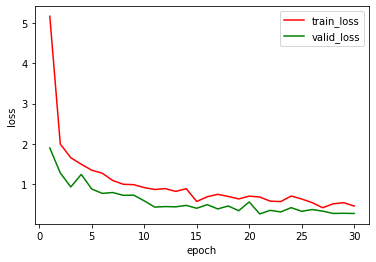

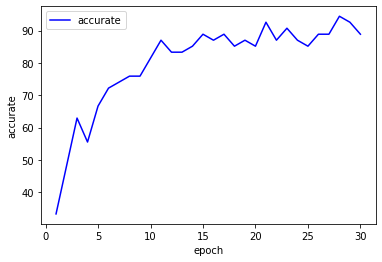


테스트셋으로 최종 정확도를 계산합니다.


100%|██████████| 30/30 [00:01<00:00, 25.64it/s]

	새로운 이미지에 대한 정확도: 83.33333333333334.


In [86]:
print("학습 종료");

import matplotlib.pyplot as plt
plt.plot(range(1, epochNum+1), train_losses, 'r', label="train_loss")
plt.plot(range(1, epochNum+1), val_losses, 'g', label="valid_loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(range(1, epochNum+1), accurates, 'b', label="accurate")
plt.xlabel('epoch')
plt.ylabel('accurate')
plt.legend()
plt.show()

print("\n테스트셋으로 최종 정확도를 계산합니다.")

def run_test(model = model, n_epochs = 1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # loss function 지정
    criterion = nn.CrossEntropyLoss()

    # optimizer로 adam 사용
    for epoch in range(1, n_epochs + 1):
        test_loss, acc = val_epoch(model, test_loader, device, criterion) # val_epoch지만 loader에 test_loader을 기입
        print(f'\t새로운 이미지에 대한 정확도: {acc}.')

run_test(model)



아직 구현실력이 부족하여 구글드라이브의 특정 위치에 사진을 업로드 하고 마운트하여 진행합니다.
분류할 사진 파일을 /content/drive/MyDrive/FingerNumber_classifier_project 경로에 newImage.png 의 이름으로 추가해주시기 바랍니다.
업로드가 완료되면 엔터를 입력해주세요.
이미지를 성공적으로 불러왔습니다!


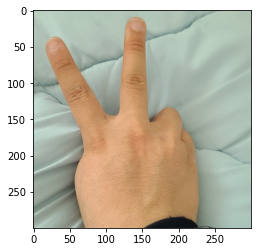

새로운 이미지 transform 적용 완료
newImage type: <class 'torch.Tensor'>, newImage shape: torch.Size([3, 224, 224])
newImage type: <class 'torch.Tensor'>, newImage shape: torch.Size([1, 3, 224, 224])
위 사진에 대한 예측 값은 9 입니다. 잘 예측이 되었을까요..?


In [87]:
# 새로운 이미지 예측해보기 
model = torch.load('/content/drive/MyDrive/FingerNumber_classifier_project/best_model.pth')
model.eval()

print("\n아직 구현실력이 부족하여 구글드라이브의 특정 위치에 사진을 업로드 하고 마운트하여 진행합니다.")
print("분류할 사진 파일을 /content/drive/MyDrive/FingerNumber_classifier_project 경로에 newImage.png 의 이름으로 추가해주시기 바랍니다.")
input("업로드가 완료되면 엔터를 입력해주세요.")

newImage = Image.open("/content/drive/MyDrive/FingerNumber_classifier_project/newImage.png").convert('RGB')
print("이미지를 성공적으로 불러왔습니다!")

transforms_new = transforms.Compose([transforms.Resize(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(0.5, 0.5)]) # 정규화

import matplotlib.image as img
import matplotlib.pyplot as pp

ndarray = img.imread('/content/drive/MyDrive/FingerNumber_classifier_project/newImage.png')

pp.imshow(ndarray)
pp.show()

newImage = transforms_new(newImage)
print("새로운 이미지 transform 적용 완료")
print(f'newImage type: {type(newImage)}, newImage shape: {newImage.shape}')

newImage = newImage.view(1, 3, 224, 224)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
newImage = newImage.to(device)
model = model.to(device)

print(f'newImage type: {type(newImage)}, newImage shape: {newImage.shape}')

with torch.no_grad():
    logits = model(newImage) # 1. forward pass
    probs = logits.softmax(1)  
    probs = probs.detach().cpu()

print(f'위 사진에 대한 예측 값은 {int(probs.argmax(1)) + 1} 입니다. 잘 예측이 되었을까요..?')


In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
